In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools

import seaborn as sns
import plotnine as p9
import collections
import statsmodels.api as sm

In [27]:
##### HELPER FUNCTIONS #####

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r.dropna(), level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=252)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=252)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=252)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [28]:
START_DATE = '2018-12-02'
END_DATE = '2020-12-31'
X = 'EOD/RTH'
Y = 'EOD/XRT'

In [29]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key=os.getenv("QUANDL_API_KEY"),
                          start_date='2018-12-02', end_date='2020-12-31')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl already defined


In [30]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [31]:
def load_ff3():
    """
    Daily annualized returns from Fama-French website. 
    """
    df_ff3 = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily_subset.csv', index_col=None)
    df_ff3['Date'] = df_ff3["Unnamed: 0"]
    df_ff3['Date'] = pd.to_datetime(df_ff3.Date, format='%Y%m%d')
    df_ff3.set_index('Date', inplace=True)
    return df_ff3

Loading data for ETF's RTH and XRT

In [32]:
raw_data = fetch_quandl((X, Y,))

#### Qualitative discussion of XRT and RTH
RTH:
>- RTH is the VanEck Vectors Retail ETF 
>- 60% consumer cyclical, 28% consumer defensive and 12% healthcare
>- Top 3 holdings: 20% AMZN, 10% HD and 8% WMT

XRT:
>- XRT is the SPDR S&P Retail ETF
>- 76% consumer cyclical, 13% consumer defensive and 5% communication services
>- Top 3 holdings: 6% GME, 2% MGNI and 2% SIG

XRT does have a skew towards consumer cyclicals. Based on top 3 holdings, a large portion of RTH's holdings are concentrated in Amazon, Home Depot and Walmart

In [33]:
df = clean_quandl_columns(raw_data)

In [34]:
df_ff3 = load_ff3()
df_ff3 = df_ff3[START_DATE:END_DATE]

In [35]:
df = df[['RTH:Adj_Close',
         'RTH:Adj_Volume',
         'XRT:Adj_Close',
         'XRT:Adj_Volume',
        ]]

In [36]:
df['RTH:Adj_Dollar_Volume'] = df['RTH:Adj_Close'] * df['RTH:Adj_Volume']
df['XRT:Adj_Dollar_Volume'] = df['XRT:Adj_Close'] * df['XRT:Adj_Volume']

#### Plot of 15-day rolling median of daily dollar volume (adjusted) for RTH and XRT
We can see how RTH is the less liquid of the two ETF's

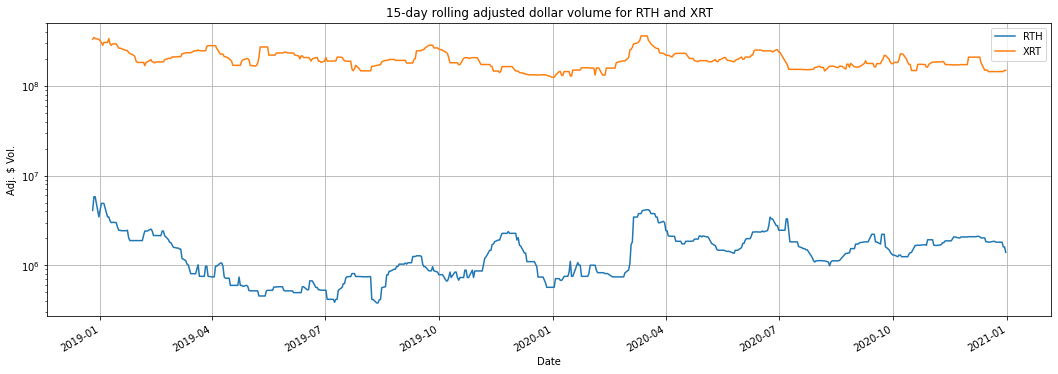

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(18,6))
df['RTH:Adj_Dollar_Volume'].shift(1).rolling(15).median().plot(grid=True, ax=axs, label='RTH', logy=True)
df['XRT:Adj_Dollar_Volume'].shift(1).rolling(15).median().plot(grid=True, ax=axs, label='XRT', logy=True)
axs.set(ylabel='Adj. $ Vol.', title='15-day rolling adjusted dollar volume for RTH and XRT')
axs.legend();

In [38]:
df[['RTH:Adj_Dollar_Volume', 'XRT:Adj_Dollar_Volume']].describe([x/10 for x in range(1,10)] + [0.005, 0.995]).style.format('{:,.0f}')

,RTH:Adj_Dollar_Volume,XRT:Adj_Dollar_Volume
count,524,524
mean,"1,940,012","210,342,779"
std,"2,056,470","86,897,909"
min,"108,254","36,440,768"
0.5%,"171,892","63,712,377"
10%,"449,269","124,371,879"
20%,"682,255","139,959,802"
30%,"889,007","158,690,567"
40%,"1,118,284","172,861,799"
50%,"1,371,564","191,948,523"


Based on the stipulated conditions in the HW, the capital K should be approximately 40 million.

In [39]:
df['Nt'] = df['RTH:Adj_Dollar_Volume'].shift(1).rolling(15).median() # Nt is supposed to have the rolling median of the dollar volume of the less liquid security RTH

#### Plot of prices, log-returns and distribution of log-returns for RTH and XRT

In [40]:
df['RTH:log_ret'] = np.log(df['RTH:Adj_Close']/df['RTH:Adj_Close'].shift(1))
df['XRT:log_ret'] = np.log(df['XRT:Adj_Close']/df['RTH:Adj_Close'].shift(1))

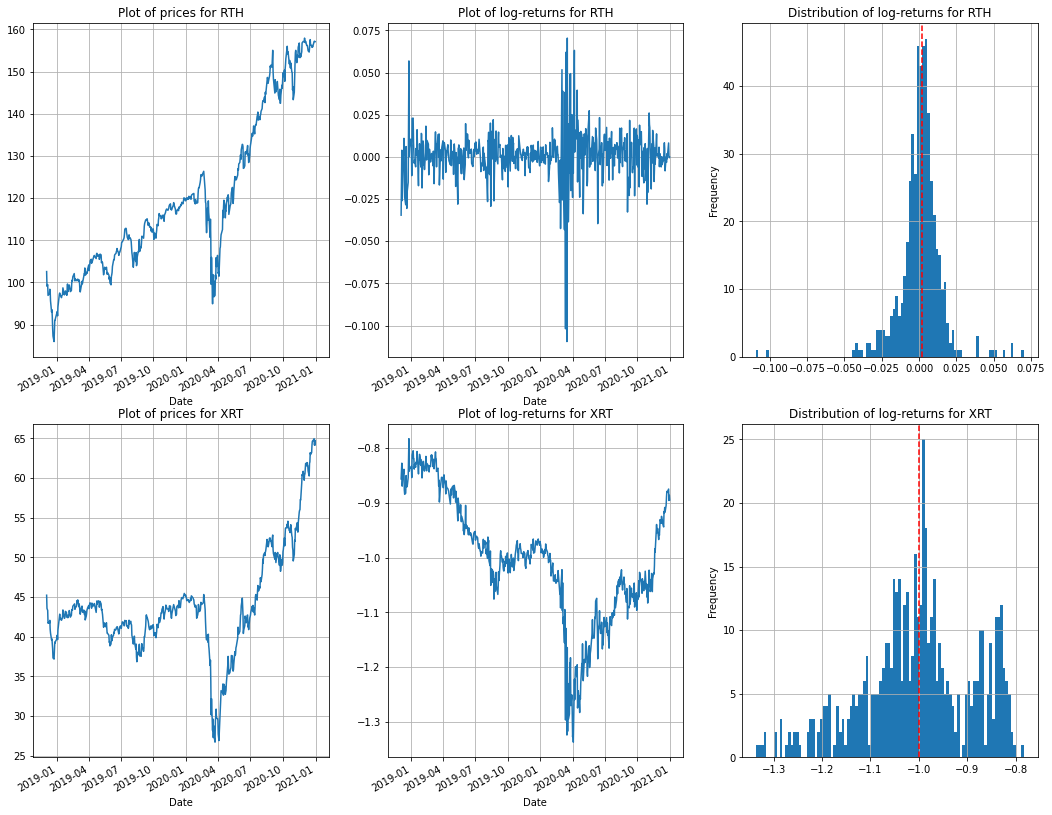

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(18, 15))
df['RTH:Adj_Close'].plot(ax=axs[0, 0], title='Plot of prices for RTH', grid=True)
df['RTH:log_ret'].plot(ax=axs[0, 1], title='Plot of log-returns for RTH', grid=True)
df['RTH:log_ret'].plot(kind='hist', bins=100, ax=axs[0, 2], title='Distribution of log-returns for RTH', grid=True)
axs[0, 2].axvline(df['RTH:log_ret'].median(), color='red', linestyle='--')

df['XRT:Adj_Close'].plot( ax=axs[1, 0], title='Plot of prices for XRT', grid=True)
df['XRT:log_ret'].plot(ax=axs[1, 1], grid=True, title='Plot of log-returns for XRT',)
df['XRT:log_ret'].plot(kind='hist', bins=100, ax=axs[1, 2], grid=True, title='Distribution of log-returns for XRT',);
axs[1, 2].axvline(df['XRT:log_ret'].median(), color='red', linestyle='--');

In [42]:
df[['RTH:log_ret', 'XRT:log_ret']].describe([x/10 for x in range(1,10)] + [0.005, 0.995]).T.style.format('{:.3f}')

,count,mean,std,min,0.5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99.5%,max
RTH:log_ret,523.000,0.001,0.015,-0.110,-0.043,-0.014,-0.006,-0.003,-0.000,0.002,0.004,0.006,0.009,0.014,0.059,0.070
XRT:log_ret,523.000,-1.005,0.115,-1.337,-1.320,-1.159,-1.091,-1.051,-1.026,-1.000,-0.983,-0.956,-0.886,-0.842,-0.807,-0.783


The distribution of log-returns is wider for XRT. The price trends were quite different before the pandemic. XRT was flat with a clear resistance at 45 but RTH had an increasing trend. This is expected since Amazon, Walmart and Home Depot have shown strong, sustainable growth over the last few years

#### Studying the difference between the rolling log-returns of RTH and XRT

In [43]:
long_leg = 'RTH:log_ret'
short_leg = 'XRT:log_ret'
df_spreads = pd.DataFrame()

for rolling_period in range(1, 51):
    df_spreads[rolling_period] = df[long_leg].rolling(rolling_period).sum() - df[short_leg].rolling(rolling_period).sum()

In [44]:
df_spread_stats = df_spreads.describe([x/10 for x in range(1,10)] + [0.005, 0.995])

The entry exit points of the strategy are based on the difference in $M$ period returns between RTH and XRT.
Here we study the difference in rolling $M$-day returns between RTH and XRT

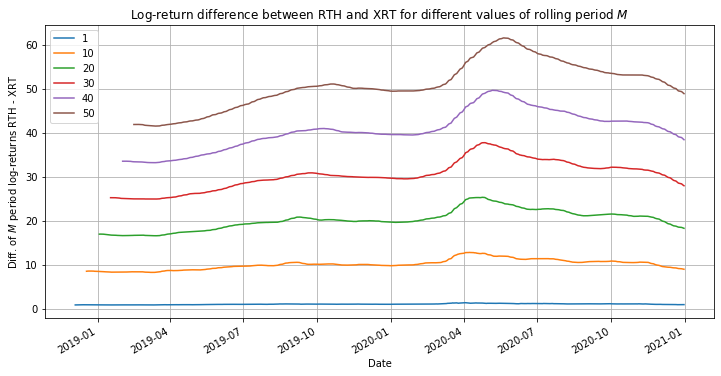

In [45]:
df_spreads[[1, 10, 20, 30, 40, 50]].plot(figsize=(12, 6), grid=True, 
                                         ylabel='Diff. of $M$ period log-returns RTH - XRT',
                                         title='Log-return difference between RTH and XRT for different values of rolling period $M$');

In this plot we study how the distribution of log-return difference changes as we increase $M$. One can see how the difference becomes wider. The "outliers" (99.5 and 0.5 percentiles) are not that far away from 2-stdev range. All of this, indicates a fairly well-behaved distribution of log-return differences

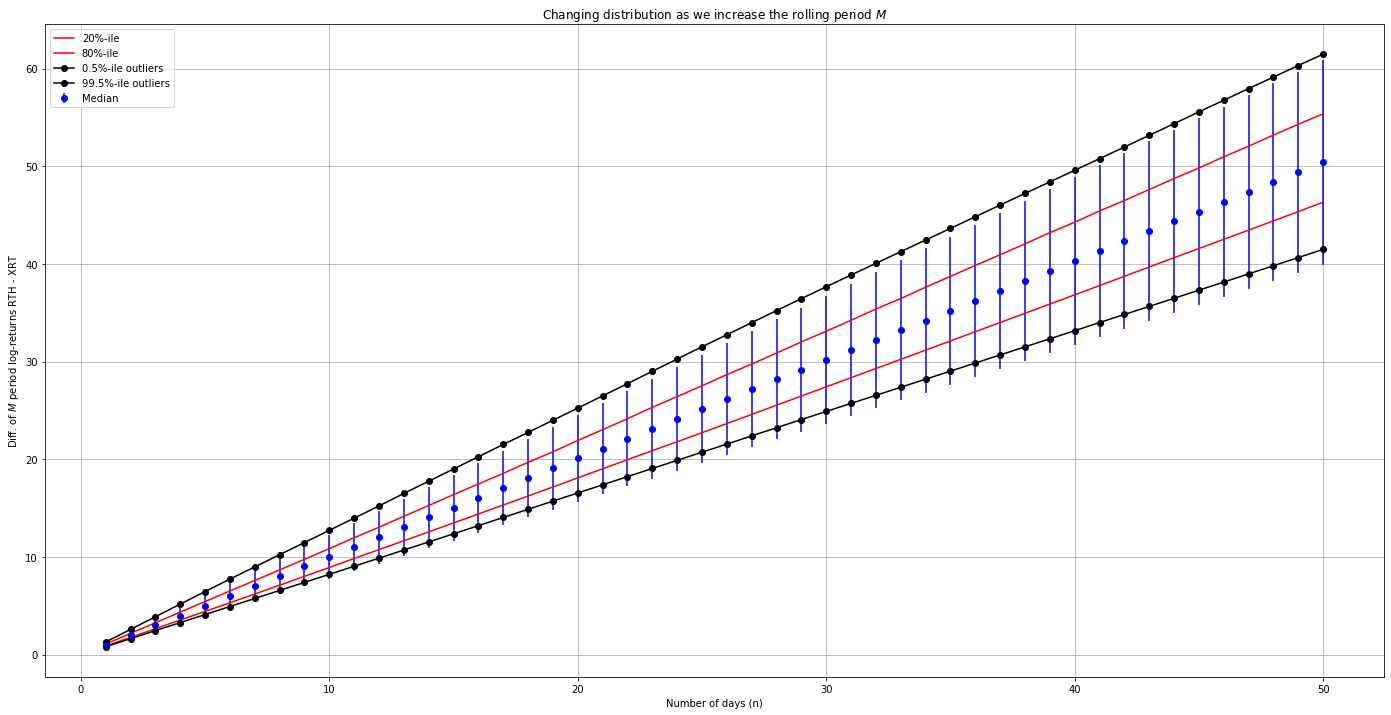

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.errorbar(df_spread_stats.T['50%'].index, df_spread_stats.T['50%'], yerr=2*df_spread_stats.T['std'], fmt='o', color='blue', 
            label='Median'
            );


# 20 and 80 pctiles
ax.plot(df_spread_stats.T['20%'].index, df_spread_stats.T['20%'], color='red', label='20%-ile');
ax.plot(df_spread_stats.T['80%'].index, df_spread_stats.T['80%'], color='red', label='80%-ile');

# using 0.5 and 99.5 pctiles as outliers
ax.plot(df_spread_stats.T['0.5%'].index, df_spread_stats.T['0.5%'], color='black', marker='o', label='0.5%-ile outliers');
ax.plot(df_spread_stats.T['99.5%'].index, df_spread_stats.T['99.5%'], color='black', marker='o', label='99.5%-ile outliers');


ax.set(xlabel='Number of days (n)',
       ylabel='Diff. of $M$ period log-returns RTH - XRT',
       title='Changing distribution as we increase the rolling period $M$');
ax.grid(True)
ax.legend();

In [49]:
# we want to find first and last trading day of the month
# Don't restrict to day = 1 or day = 30/31 on account of holidays
df['dtformat'] = df.index.strftime('%Y%m')
df['dt'] = df.index
df['last_trading_day_month'] = df.index == df.dtformat.map(df.groupby(['dtformat'])['dt'].max().to_dict())
df['first_trading_day_month'] = df.index == df.dtformat.map(df.groupby(['dtformat'])['dt'].min().to_dict())
del df['dtformat']
del df['dt']

Any strategy that we design has to account for the increasing median and widening distribution, and then adjust the entry, exit and stop-loss points accordingly.

In [50]:
def produce_trading_strategy(df, long_leg, short_leg, M, j, g, exit_stop_loss):
    """
    Simulate the strategy for a given spread. 
    long_leg corresponds to the long leg of the spread.
    M corresponds to the period for rolling returns
    j is the lower bound and g is the upper bound
    exit_stop_loss is position_value / gross_traded_cash ratio
    below which we will exit our position
    Returns a dataframe with our capital stock worth at each point of time
    """
    df_strat = df.copy()
    
    # first find the s based on the rolling period M specified. 
    df_strat['s'] = df_strat[long_leg + ':log_ret'].rolling(M).sum() - df_strat[short_leg + ':log_ret'].rolling(M).sum() 
    df_strat['curr_pos'] = None
    df_strat['entry_point'] = False
    df_strat['exit_point'] = False
    df_strat['capital'] = 0 

    curr_pos = None
    curr_num_short_leg = 0
    curr_num_long_leg = 0
    entry_price_short_leg = 0
    entry_price_long_leg = 0 
    gross_traded_cash = 0
    position_value = 0
    capital = df.Nt.max() * 2 # specified in section 3.5 of the homework

    df_strat[long_leg + ':num_shares'] = 0
    df_strat[long_leg + ':entry_price'] = 0
    
    df_strat[short_leg + ':num_shares'] = 0
    df_strat[short_leg + ':entry_price'] = 0
    
    df_strat['position_value'] = 0 # this is reset upon every entry/exit transaction. Thus, it is unique to each position
    
    for idx, row in df_strat.iterrows():
        
        nt = row.Nt / 100 # we want our short/long cash position to be 1% of Nt
        
        # if the spread value has cross our set upper bound then go short on the spread, i.e. short the long leg and long the short leg
        # of the spread
        if row.s >= g and pd.notnull(nt) and row.first_trading_day_month:            
            # if it is not short already then enter the short position
            if curr_pos != 'short':
                curr_pos = 'short'
                # you need the entry price into the position to mark to market
                entry_price_short_leg = row[short_leg +':Adj_Close']
                entry_price_long_leg = row[long_leg +':Adj_Close']
                curr_num_short_leg = int( nt / entry_price_short_leg)
                curr_num_long_leg = int( -1*nt / entry_price_long_leg)
                gross_traded_cash = abs(entry_price_short_leg * curr_num_short_leg) + abs(entry_price_long_leg * curr_num_long_leg)
                df_strat.loc[idx, 'entry_point'] = True
                
        # if the spread value has crossed our set lower bound then go long on the spread
        elif row.s <= j and pd.notnull(nt) and row.first_trading_day_month:
            # if it is not long already then enter the long position
            if curr_pos != 'long':
                curr_pos = 'long'
                entry_price_short_leg = row[short_leg +':Adj_Close']
                entry_price_long_leg = row[long_leg +':Adj_Close']
                curr_num_short_leg = int( -1*nt / entry_price_short_leg)
                curr_num_long_leg = int( nt / entry_price_long_leg)
                gross_traded_cash = abs(entry_price_short_leg * curr_num_short_leg) + abs(entry_price_long_leg * curr_num_long_leg)
                df_strat.loc[idx, 'entry_point'] = True
                
        df_strat.loc[idx, 'curr_pos'] = curr_pos
        df_strat.loc[idx, long_leg + ':num_shares'] = curr_num_long_leg
        df_strat.loc[idx, short_leg + ':num_shares'] = curr_num_short_leg
        df_strat.loc[idx, long_leg + ':entry_price'] = entry_price_long_leg
        df_strat.loc[idx, short_leg + ':entry_price'] = entry_price_short_leg
        df_strat.loc[idx, 'gross_traded_cash'] = gross_traded_cash
        
        today_position_value = curr_num_long_leg * (row[long_leg + ':Adj_Close'] - entry_price_long_leg) 
        today_position_value += curr_num_short_leg * (row[short_leg + ':Adj_Close'] - entry_price_short_leg)
        change_in_pos_val = today_position_value - position_value # this will be added to capital
        position_value = today_position_value
        df_strat.loc[idx, 'position_value'] = position_value 
        
        capital += change_in_pos_val
        df_strat.loc[idx, 'capital'] = capital
        
        if (position_value != 0 and gross_traded_cash != 0 and position_value / gross_traded_cash <= exit_stop_loss):
            # close position
            df_strat.loc[idx, 'exit_point'] = True
            
        if curr_pos is not None and row.last_trading_day_month:
            # if you have an ongoing position and it's the last trading day of the month - exit
            df_strat.loc[idx, 'exit_point'] = True
            
        if df_strat.loc[idx, 'exit_point']:
            curr_pos = None
            entry_price_short_leg = 0
            entry_price_long_leg = 0
            curr_num_short_leg = 0
            curr_num_long_leg = 0
            gross_traded_cash = 0
            position_value = 0 # reset position value
        
    if df_strat.loc[idx, 'curr_pos'] is not None:
        df_strat.loc[idx, 'exit_point'] = True
        df_strat.loc[idx, 'curr_pos'] = None
            
    return df_strat

In [51]:
# Running a grid search on our entry exit points, rolling period as well as stop loss
ls_grid_cells = []
strat_grid_record = collections.namedtuple('Record', 'M j g s end_capital')
for M in [10, 20, 30, 40, 50]:
    sigma = df_spread_stats[M]['std']
    mu = df_spread_stats[M]['mean']
    for sigma_mult in [1, 2, 3]:
        for s in np.linspace(0, -0.05, 5):
                j = mu - sigma_mult*sigma
                g = mu + sigma_mult*sigma
                try:
                    df_strat_for_grid_cell = produce_trading_strategy(df, 
                             'RTH', 
                             'XRT', 
                             M, j, g,
                            exit_stop_loss = s,
                            )
                    final_capital = df_strat_for_grid_cell.tail(1).capital.values[0]
                    cell_to_add = strat_grid_record(M=M, j=j, g=g, s=s, end_capital=final_capital)
                    ls_grid_cells.append(cell_to_add)
                except:
                    print(M, j, g, s)

In [52]:
df_grid = pd.DataFrame(ls_grid_cells)

In [53]:
df_grid['sigma'] = df_grid.M.apply(lambda x: df_spread_stats[x]['std'])
df_grid['spread_width'] = (df_grid['g'] - df_grid['j'])/(2*df_grid['sigma'])
df_grid['spread_width'] = df_grid['spread_width'].apply(round)
df_grid['s'] = df_grid['s'].apply(lambda x: round(x, 3))

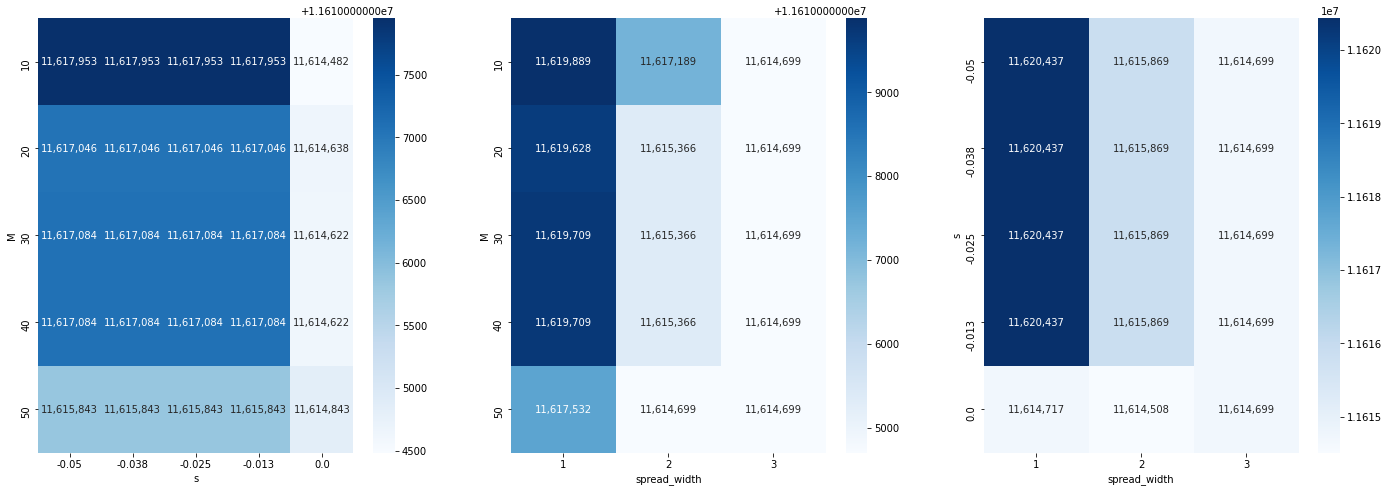

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
sns.heatmap(pd.pivot_table(df_grid, index='M', columns='s', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(pd.pivot_table(df_grid, index='M', columns='spread_width', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[1]);
sns.heatmap(pd.pivot_table(df_grid, index='s', columns='spread_width', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[2]);

Based on these heatmaps:
>- You want the spread width to be as low as possible. If you check out both the M-width and s-width plots, the sensitivity is stronger for width. 
>- M is optimal at 10. In M-s plot, you can see how the sensitivity is stronger for M. And in the M-width plot, the sensitivity is stronger for width. 
>- s should be as low as possible. But for safety we cap stop loss at 5%. This is of course based on your risk aversion. The sensitivity towards is lower in both M-s and s-width plots. 

The suggestions are quite intuitive. You want the width to be reasonably low so you can trade. You want M to be based on relatively recent values. Prices do not retain much history. s (stop loss) is based on your risk aversion but it should not be 0. 

In [55]:
M = 10
j = df_spread_stats[M]['mean'] - df_spread_stats[M]['std']
g = df_spread_stats[M]['mean'] + df_spread_stats[M]['std']
df_optimal = produce_trading_strategy(df, 
                         'RTH', 
                         'XRT', 
                         M, j, g,
                        exit_stop_loss = -0.05,
                        )

In [56]:
df_optimal['Strategy Log Returns'] = np.log(df_optimal['capital']/df_optimal['capital'].shift(1))

#### Analyzing strategy performance for optimal parameters

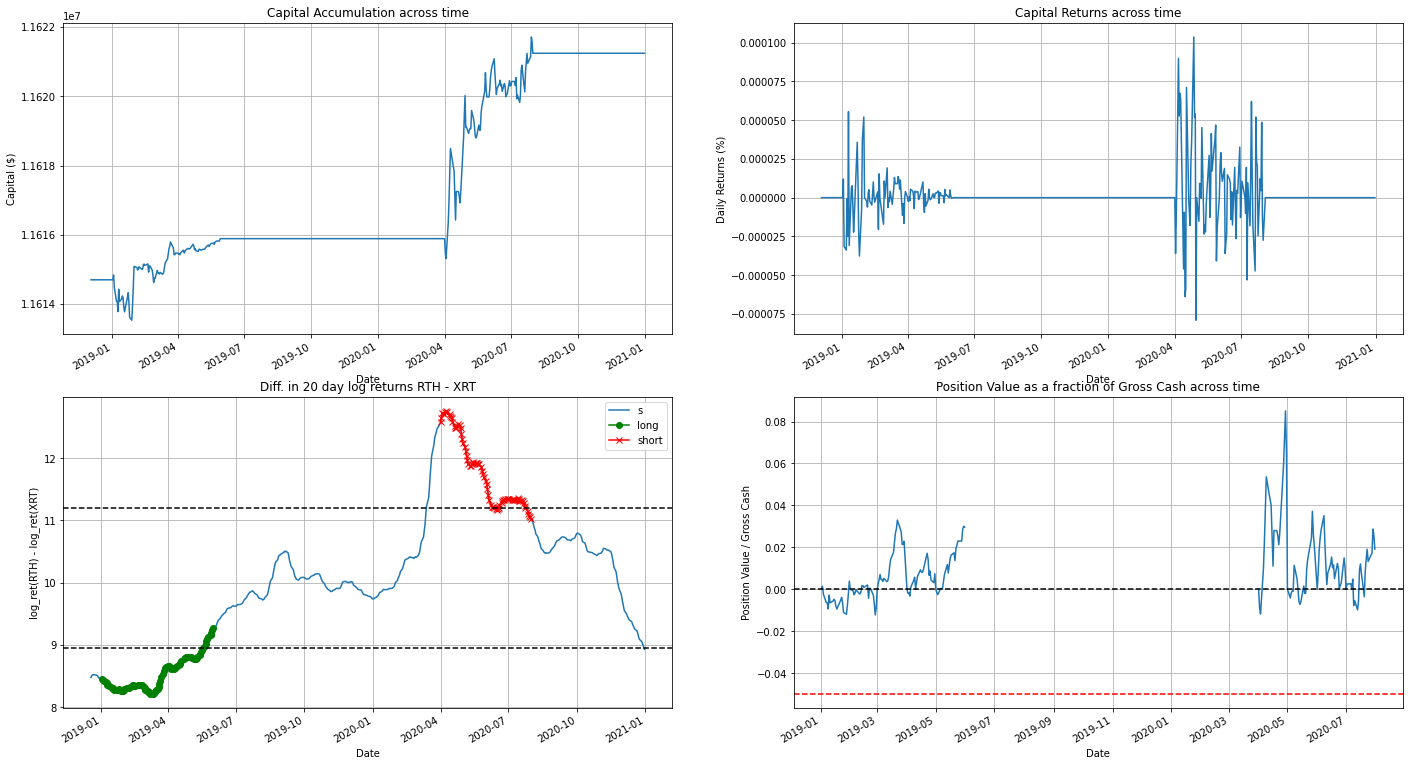

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(24, 14), sharex=False)
df_optimal.capital.plot(ax=axs[0, 0], grid=True, ylabel='Capital ($)', title='Capital Accumulation across time');
df_optimal.capital.pct_change().plot(ax=axs[0, 1], grid=True, ylabel='Daily Returns (%)', title='Capital Returns across time');


df_optimal['s'].plot(ax=axs[1, 0], label='s')
df_optimal[df_optimal.curr_pos == 'long']['s'].plot(marker='o', ax=axs[1, 0], color='green', label='long')
df_optimal[df_optimal.curr_pos == 'short']['s'].plot(marker='x', ax=axs[1, 0], color='red', label='short')
axs[1, 0].axhline(g, linestyle='--', color='black')
axs[1, 0].axhline(j, linestyle='--', color='black')
axs[1, 0].grid(True);
axs[1, 0].legend();
axs[1, 0].set(ylabel='log_ret(RTH) - log_ret(XRT)', title='Diff. in 20 day log returns RTH - XRT');

(df_optimal.position_value / df_optimal.gross_traded_cash).plot(ax=axs[1, 1], grid=True, 
                                                                title='Position Value as a fraction of Gross Cash across time',
                                                                ylabel='Position Value / Gross Cash');
axs[1, 1].axhline(s, linestyle='--', color='red');
axs[1, 1].axhline(0, linestyle='--', color='black');

In [58]:
summary_stats(df_optimal[['Strategy Log Returns']])

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Strategy Log Returns,0.000271,0.000241,1.382989,15.608489,0.000013,0.000034,-119.767815,-0.000178


Return on capital

In [59]:
print('Return on Capital = {:.3f}%'.format((df_optimal['capital'][-1]/df_optimal['capital'][0] - 1) * 100))

Return on Capital = 0.056%


#### Regressing against FF3 to study factor loadings

In [60]:
df_factor_loading = df_optimal[['Strategy Log Returns']].merge(df_ff3, how='left', left_index=True, right_index=True).dropna()

In [61]:
# annualize the log returns by multiplying with 252 and then subtract. Your FF3 returns are already annualized
res = sm.OLS((df_factor_loading['Strategy Log Returns'] * 252 - df_factor_loading['RF']),
             sm.add_constant(df_factor_loading[['Mkt-RF', 'SMB', 'HML']])).fit()

In [62]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     22.96
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           5.71e-14
Time:                        18:36:20   Log-Likelihood:                 1987.3
No. Observations:                 523   AIC:                            -3967.
Df Residuals:                     519   BIC:                            -3950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.000    -20.242      0.000      -0.005      -0.004
Mkt-RF         0.0003      0.000      2.129      0.034    2.43e-05       0.001
SMB            0.0015      0.000      4.332      0.000       0.001       0.002
HML            0.0006      0.000      2.696      0.007       0.000       0.001
==============================================================================
Omnibus:                       62.918   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.459
Skew:                           0.760   Prob(JB):                     1.26e-23
Kurtosis:                       4.590   Cond. No.                         2.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inferences from the regression:
>- The alpha is negative
>- Beta is low for Market portfolio. Based on the p-value, we can reject the null that this factor loading is 0 at 5% but not at 1%.
>- The strategy has a slight small cap tilt. We can reject the null that this factor loading is 0. 
>- It has a slight value tilt. We can reject the null that this factor loading is 0. 